# 4. Panorama Generation

In [4]:
input_dir_2 = "/kaggle/input/panorama-dataset/panorama_dataset/"
image1_path = input_dir_2 + "image1.png"
image2_path = input_dir_2 + "image2.png"

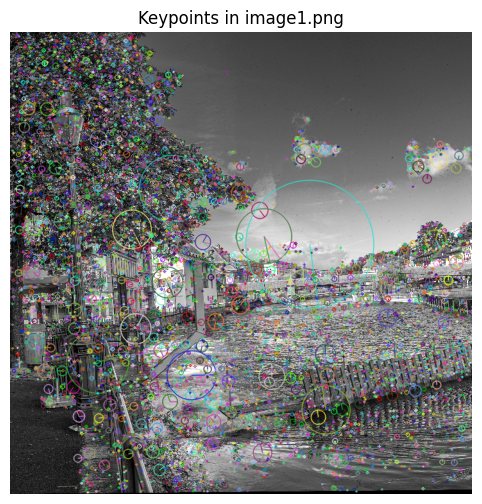

In [5]:
image1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
SIFT = cv2.SIFT_create()

keypoints1, descriptors1 = SIFT.detectAndCompute(image1, None)

image1_keypoints = cv2.drawKeypoints(image1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(8, 6))
plt.imshow(image1_keypoints, cmap='gray')
plt.axis("off")
plt.title("Keypoints in image1.png")
plt.show()

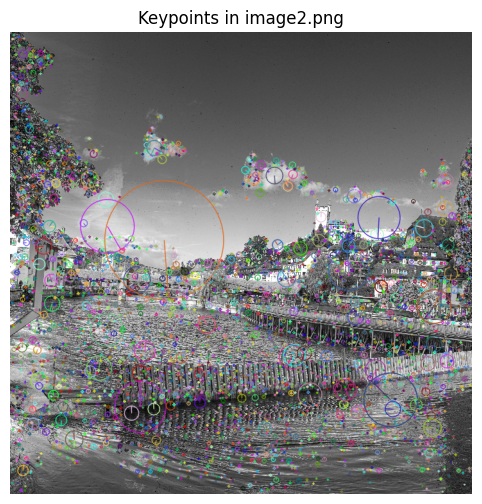

In [6]:
image2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)
SIFT = cv2.SIFT_create()

keypoints2, descriptors2 = SIFT.detectAndCompute(image2, None)

image2_keypoints = cv2.drawKeypoints(image2, keypoints2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(8, 6))
plt.imshow(image2_keypoints, cmap='gray')
plt.axis("off")
plt.title("Keypoints in image2.png")
plt.show()

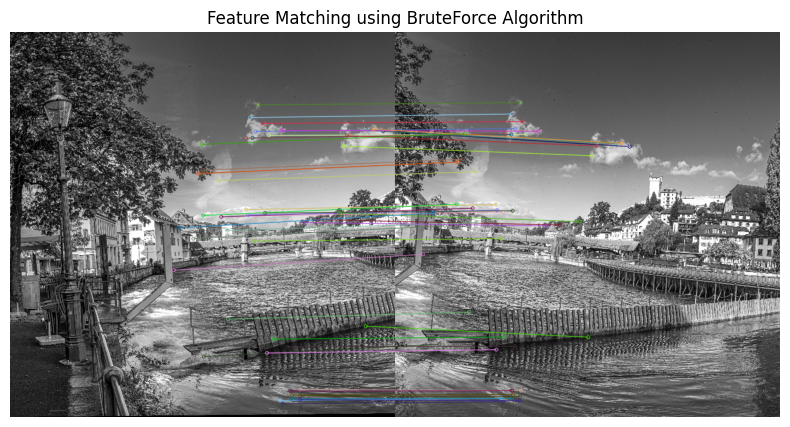

In [7]:
BF = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches_bf = BF.match(descriptors1, descriptors2)
matches_bf = sorted(matches_bf, key=lambda x: x.distance)

output_bf = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches_bf[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10, 5))
plt.imshow(output_bf)
plt.axis("off")
plt.title("Feature Matching using BruteForce Algorithm")
plt.show()

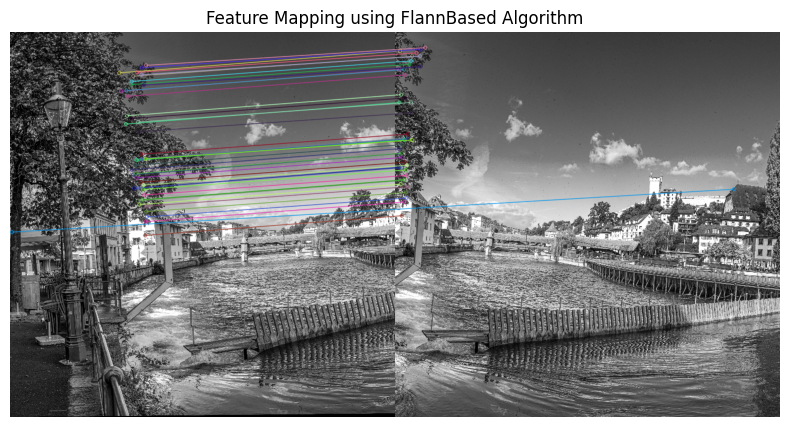

In [8]:
FLANN = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
matches_flann = FLANN.knnMatch(descriptors1, descriptors2, k=2)
req_matches_flann = [i for i, j in matches_flann if i.distance < 0.7 * j.distance]

output_flann = cv2.drawMatchesKnn(image1, keypoints1, image2, keypoints2, [req_matches_flann[:50]], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10, 5))
plt.imshow(output_flann)
plt.axis("off")
plt.title("Feature Mapping using FlannBased Algorithm")
plt.show()

In [9]:
source_pts = np.float32([keypoints1[i.queryIdx].pt for i in req_matches_flann]).reshape(-1, 1, 2)
dest_pts = np.float32([keypoints2[i.trainIdx].pt for i in req_matches_flann]).reshape(-1, 1, 2)

H, mask = cv2.findHomography(source_pts, dest_pts, cv2.RANSAC, 5.0)

np.savetxt("homography_matrix.csv", H, delimiter=',', fmt="%0.6f")

In [10]:
H

array([[ 8.99134087e-01, -1.31531656e-01, -1.64406566e+02],
       [ 1.43371278e-01,  9.90809456e-01, -6.95088198e+01],
       [ 3.91882263e-08,  5.19780356e-07,  1.00000000e+00]])

In [11]:
height, width = image1.shape[:2]

corners = [[0, 0], [width, 0], [width, height], [0, height]]
corners = np.array(corners, dtype=np.float32).reshape(-1, 1, 2)

transformed_corners = cv2.perspectiveTransform(corners, H)

In [12]:
all_corners = np.vstack((transformed_corners.reshape(-1, 2), [[0, 0], [width, 0], [width, height], [0, height]]))
min_x, min_y = np.int32(all_corners.min(axis=0))
max_x, max_y = np.int32(all_corners.max(axis=0))

translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])
H_translated = translation_matrix @ H

In [13]:
warped_image1 = cv2.warpPerspective(image1, H_translated, (max_x - min_x, max_y - min_y))

warped_image2 = np.zeros_like(warped_image1)
warped_image2[-min_y: height - min_y, -min_x: width - min_x] = image2

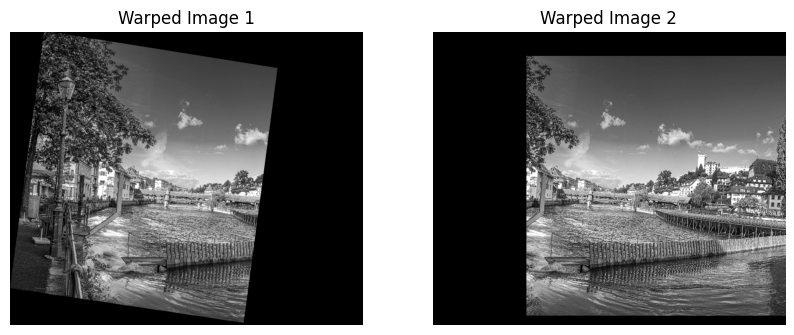

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(warped_image1, cmap='gray')
plt.axis("off")
plt.title("Warped Image 1")

plt.subplot(1, 2, 2)
plt.imshow(warped_image2, cmap='gray')
plt.axis("off")
plt.title("Warped Image 2")
plt.show()

In [15]:
panorama1 = warped_image1.copy()
panorama1[-min_y: height - min_y, -min_x: width - min_x] = image2

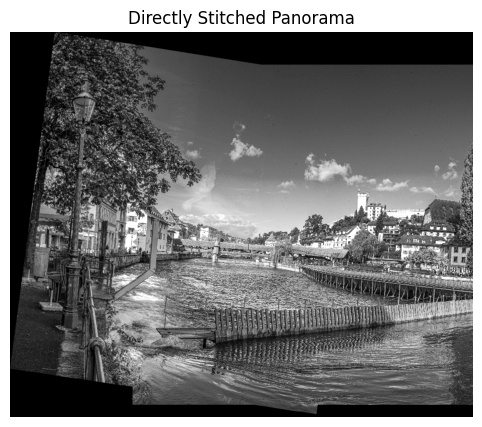

In [16]:
plt.figure(figsize=(10, 5))
plt.imshow(panorama1, cmap='gray')
plt.axis("off")
plt.title("Directly Stitched Panorama")
plt.show()

In [17]:
panorama1.shape

(815, 979)

In [19]:
panorama2 = panorama1.copy()
# panorama2 = cv2.cvtColor(panorama2, cv2.COLOR_BGR2GRAY)

_, thresh = cv2.threshold(panorama2, 1, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
x, y, w, h = cv2.boundingRect(contours[0])

cropped_panorama2 = panorama2[y: y+h, x: x+w]

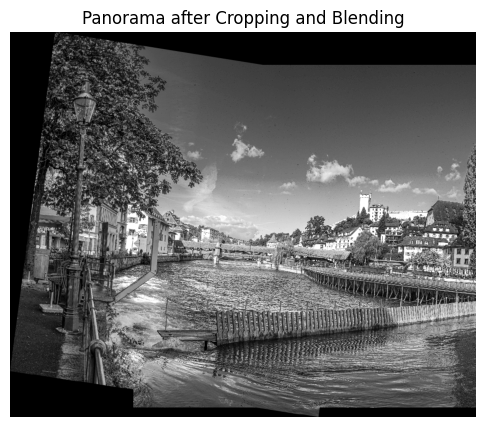

In [20]:
plt.figure(figsize=(10, 5))
plt.imshow(cropped_panorama2, cmap='gray')
plt.axis("off")
plt.title("Panorama after Cropping and Blending")
plt.show()

In [21]:
print(len(sorted(glob.glob(input_dir_2 + "*.png"))))

24


In [22]:
def extract_color_histogram(image_path, bins=(8, 8, 8)):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)

    return hist.flatten()

In [27]:
def cluster_images_color_histogram(image_dir, n_clusters=3):
    images_paths = sorted([os.path.join(image_dir, image_name) for image_name in os.listdir(image_dir)])
    features = np.array([extract_color_histogram(image_path) for image_path in images_paths])
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features)
    clustered_images = {i: [] for i in range(n_clusters)}

    for i in range(len(images_paths)):
        clustered_images[labels[i]].append(images_paths[i])

    return clustered_images

In [28]:
"""
{0: ['/kaggle/input/panorama-dataset/panorama_dataset/e.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/g.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/k.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/l.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/m.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/p.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/t.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/v.png'],
 1: ['/kaggle/input/panorama-dataset/panorama_dataset/b.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/d.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/h.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/j.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/o.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/r.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/s.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/u.png'],
 2: ['/kaggle/input/panorama-dataset/panorama_dataset/a.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/c.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/f.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/i.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/image1.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/image2.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/n.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/q.png']}
"""

clustered_images_1 = cluster_images_color_histogram(input_dir_2)

In [29]:
clustered_images_1

{0: ['/kaggle/input/panorama-dataset/panorama_dataset/e.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/g.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/k.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/l.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/m.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/p.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/t.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/v.png'],
 1: ['/kaggle/input/panorama-dataset/panorama_dataset/b.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/d.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/h.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/j.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/o.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/r.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/s.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/u.png'],
 2: ['/kaggle/input/panorama-dataset/panorama_da

In [30]:
def cluster_images_visual_BOW(image_dir, n_clusters=3, vocab_size=20):
    images_paths = sorted(glob.glob(image_dir + "*.png"))
    final_descriptors = []
    image_descriptors = {}

    for image_path in images_paths:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        SIFT = cv2.SIFT_create()
        _, descriptors = SIFT.detectAndCompute(image, None)

        if descriptors is not None:
            final_descriptors.append(descriptors)
            image_descriptors[image_path] = descriptors

    if len(final_descriptors) == 0:
        print("No descriptors")
        return final_descriptors

    final_descriptors = np.vstack(final_descriptors)
    kmeans = KMeans(n_clusters=vocab_size, random_state=42, n_init=10)
    kmeans.fit(final_descriptors)

    feature_vectors = []
    for image_path, descriptors in image_descriptors.items():
        words = kmeans.predict(descriptors)
        hist, _ = np.histogram(words, bins=range(vocab_size + 1))
        feature_vectors.append(hist)

    scaler = StandardScaler()
    feature_vectors = scaler.fit_transform(np.array(feature_vectors))

    image_clusters = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit_predict(feature_vectors)
    clustered_images = {i: [] for i in range(n_clusters)}

    images_paths = list(image_descriptors.keys())
    for i in range(len(images_paths)):
        clustered_images[image_clusters[i]].append(images_paths[i])

    return clustered_images

In [31]:
"""
{0: ['/kaggle/input/panorama-dataset/panorama_dataset/b.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/d.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/h.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/image2.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/j.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/m.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/n.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/r.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/s.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/t.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/u.png'],
 1: ['/kaggle/input/panorama-dataset/panorama_dataset/e.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/g.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/k.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/l.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/o.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/p.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/v.png'],
 2: ['/kaggle/input/panorama-dataset/panorama_dataset/a.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/c.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/f.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/i.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/image1.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/q.png']}
"""

clustered_images_2 = cluster_images_visual_BOW(input_dir_2)

In [32]:
clustered_images_2

{0: ['/kaggle/input/panorama-dataset/panorama_dataset/b.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/d.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/h.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/image2.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/j.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/m.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/n.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/r.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/s.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/t.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/u.png'],
 1: ['/kaggle/input/panorama-dataset/panorama_dataset/e.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/g.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/k.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/l.png',
  '/kaggle/input/panorama-dataset/panorama_dataset/o.png',
  '/kaggle/input/panorama-dataset/panorama_d

In [33]:
def stitch_images(image_paths):
    # This Multi-image stitching is using Stitcher_create() function
    stitcher = cv2.Stitcher_create()
    images = [cv2.imread(image_path) for image_path in image_paths]

    status, panorama = stitcher.stitch(images)

    if status == cv2.STITCHER_OK:
        return panorama

    else:
        print("Stitching failed!")
        return None

In [34]:
panorama_1 = stitch_images(clustered_images_1[0])

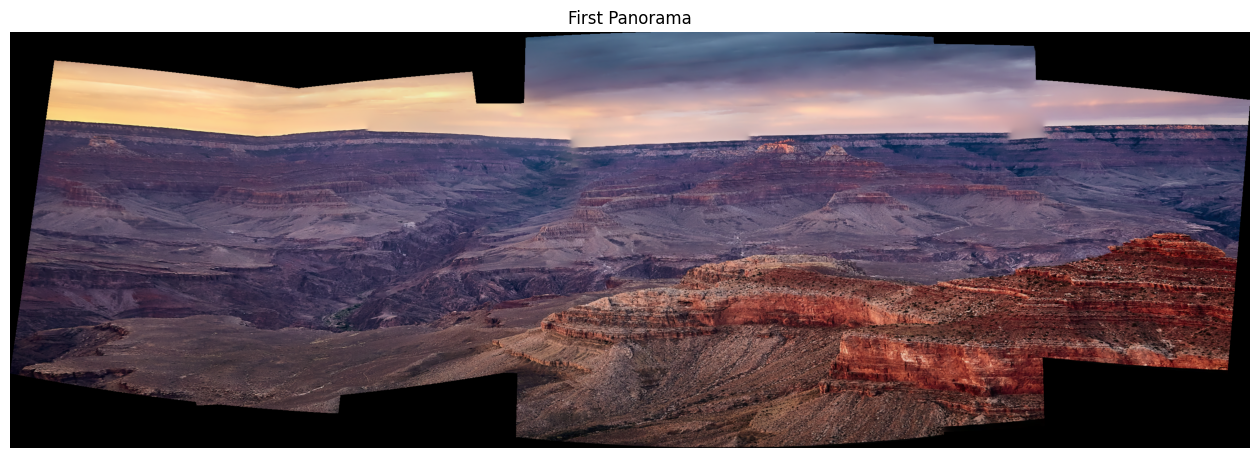

In [35]:
plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(panorama_1, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("First Panorama")
plt.show()

In [36]:
panorama_2 = stitch_images(clustered_images_1[1])

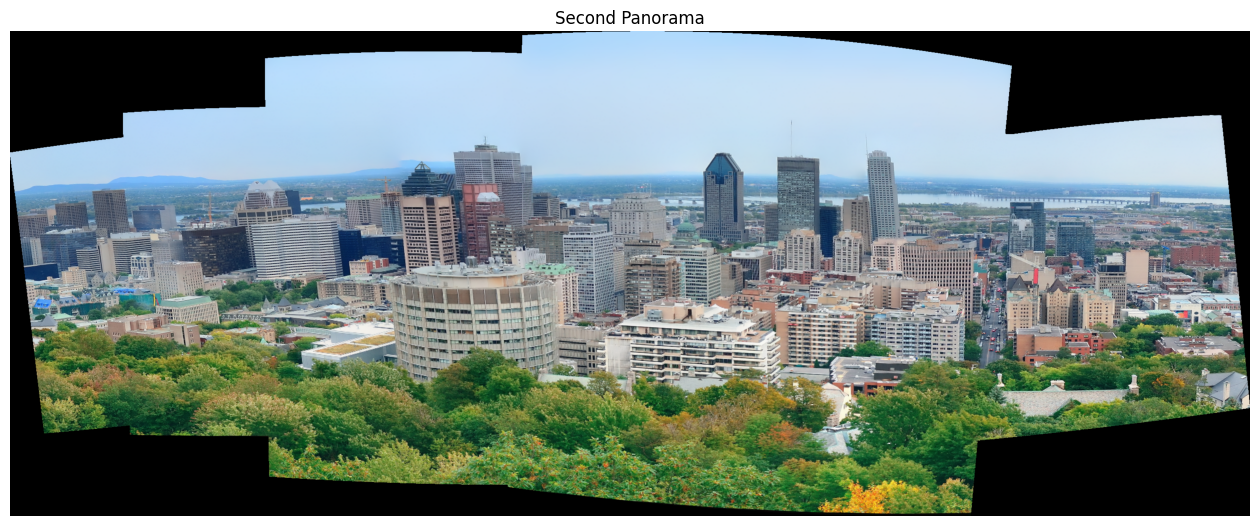

In [37]:
plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(panorama_2, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Second Panorama")
plt.show()

In [38]:
panorama_3 = stitch_images(clustered_images_1[2])

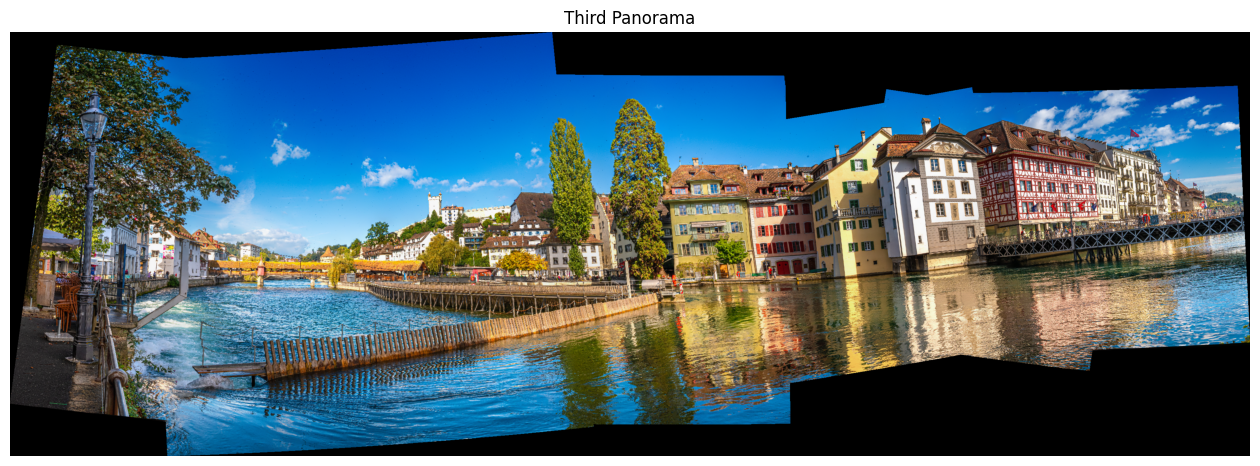

In [39]:
plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(panorama_3, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Third Panorama")
plt.show()

In [40]:
clustered_images_1[0] = [
    '/kaggle/input/panorama-dataset/panorama_dataset/g.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/v.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/p.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/t.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/k.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/l.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/m.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/e.png'
]

clustered_images_1[1] = [
    '/kaggle/input/panorama-dataset/panorama_dataset/h.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/j.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/o.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/r.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/s.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/d.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/u.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/b.png'
]

clustered_images_1[2] = [
    '/kaggle/input/panorama-dataset/panorama_dataset/image1.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/image2.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/a.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/n.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/c.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/q.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/i.png',
    '/kaggle/input/panorama-dataset/panorama_dataset/f.png'
]

In [43]:
def get_SIFT_keypt_desc(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    SIFT = cv2.SIFT_create()

    keypts, descs = SIFT.detectAndCompute(image, None)

    return keypts, descs, image

def flann_matching(desc1, desc2):
    FLANN = cv2.FlannBasedMatcher(dict(algorithm=1, tree=5), dict(checks=50))
    matches = FLANN.knnMatch(desc1, desc2, k=2)
    req_matches_flann = [i for i, j in matches if i.distance < 0.7 * j.distance]

    return req_matches_flann

def bf_matching(desc1, desc2):
    BF = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = BF.knnMatch(desc1, desc2, k=2)
    req_matches_bf = [m for m, n in matches if m.distance < 0.75 * n.distance]
    
    return req_matches_bf

def get_homography(keypts1, keypts2, matching):
    if len(matching) < 4:
        print("Insufficient matches found")
        return None, None
    
    source_pts = np.float32([keypts1[i.queryIdx].pt for i in matching]).reshape(-1, 1, 2)
    dest_pts = np.float32([keypts2[i.trainIdx].pt for i in matching]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(source_pts, dest_pts, cv2.RANSAC, 5.0)

    return H, mask

In [49]:
def stitch_images(images_paths):
    keypts1, descs1, base_image = get_SIFT_keypt_desc(images_paths[0])

    for i in range(1, len(images_paths)):
        print(i)
        keypts2, descs2, next_image = get_SIFT_keypt_desc(images_paths[i])

        matches = bf_matching(descs1, descs2)

        if len(matches) < 10:
            print("Insufficient matches found for image",  i)
            continue

        H, mask = get_homography(keypts1, keypts2, matches)
        if H is None:
            print("Skipping image", i)
            continue

        # height, width = image1.shape[:2]

        # corners = [[0, 0], [width, 0], [width, height], [0, height]]
        # corners = np.array(corners, dtype=np.float32).reshape(-1, 1, 2)
        
        # transformed_corners = cv2.perspectiveTransform(corners, H)
        
        # all_corners = np.vstack((transformed_corners.reshape(-1, 2), [[0, 0], [width, 0], [width, height], [0, height]]))
        # min_x, min_y = np.int32(all_corners.min(axis=0))
        # max_x, max_y = np.int32(all_corners.max(axis=0))
        
        # translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])
        # H_translated = translation_matrix @ H
        
        # warped_image1 = cv2.warpPerspective(image1, H_translated, (max_x - min_x, max_y - min_y))
        
        # warped_image2 = np.zeros_like(warped_image1)
        # warped_image2[-min_y: height - min_y, -min_x: width - min_x] = image2
        
        height1, width1 = base_image.shape[:2]
        height2, width2 = next_image.shape[:2]

        corners1 = [[0, 0], [width1, 0], [width1, height1], [0, height1]]
        corners1 = np.array(corners1, dtype=np.float32).reshape(-1, 1, 2)
        transformed_corners1 = cv2.perspectiveTransform(corners1, H)
        

        all_corners2 = np.vstack((transformed_corners1.reshape(-1, 2), [[0, 0], [width2, 0], [width2, height2], [0, height2]]))
        min_x2, min_y2 = np.int32(all_corners2.min(axis=0))
        max_x2, max_y2 = np.int32(all_corners2.max(axis=0))
        
        translation_matrix2 = np.array([[1, 0, -min_x2], [0, 1, -min_y2], [0, 0, 1]], dtype=np.float32)
        H_translated2 = translation_matrix2 @ H
        
        warped_image1 = cv2.warpPerspective(base_image, H_translated2, (max_x2 - min_x2, max_y2 - min_y2))
        # warped_image2 = np.zeros_like(warped_image1)

        # warped_image2[-min_y2: height2 - min_y2, -min_x2: width2 - min_x2] = next_image

        warped_image2 = cv2.warpPerspective(next_image, translation_matrix2, (max_x2 - min_x2, max_y2 - min_y2))

        mask1 = (warped_image1 > 0).astype(np.uint8)
        mask2 = (warped_image2 > 0).astype(np.uint8)
        combined_mask = mask1 + mask2

        blended = (warped_image1.astype(np.float32) + warped_image2.astype(np.float32)) / np.maximum(combined_mask, 1)
        base_image = np.uint8(blended)

        # base_image = warped_image2
        keypts1, descs1 = keypts2, descs2

        plt.figure(figsize=(6, 3))
        plt.imshow(cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Panorama after iteration" + str(i))
        plt.show()

    return base_image

1


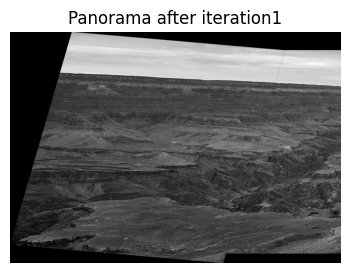

2


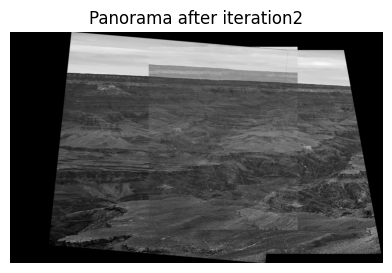

3


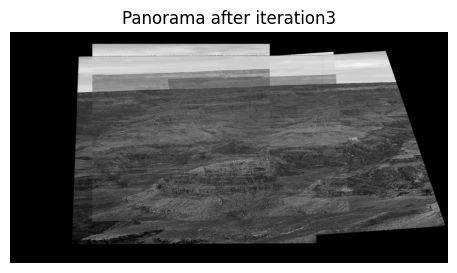

4


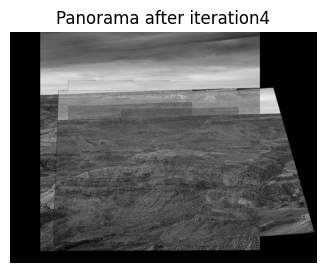

5


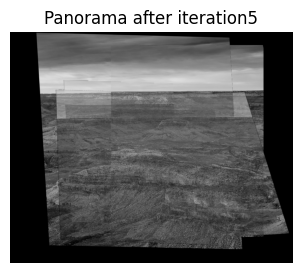

6


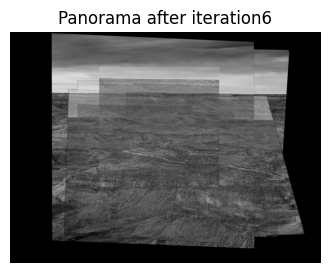

7


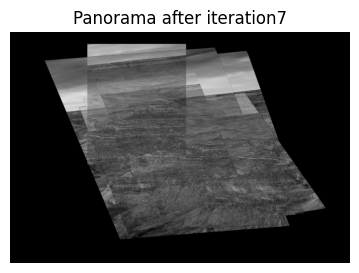

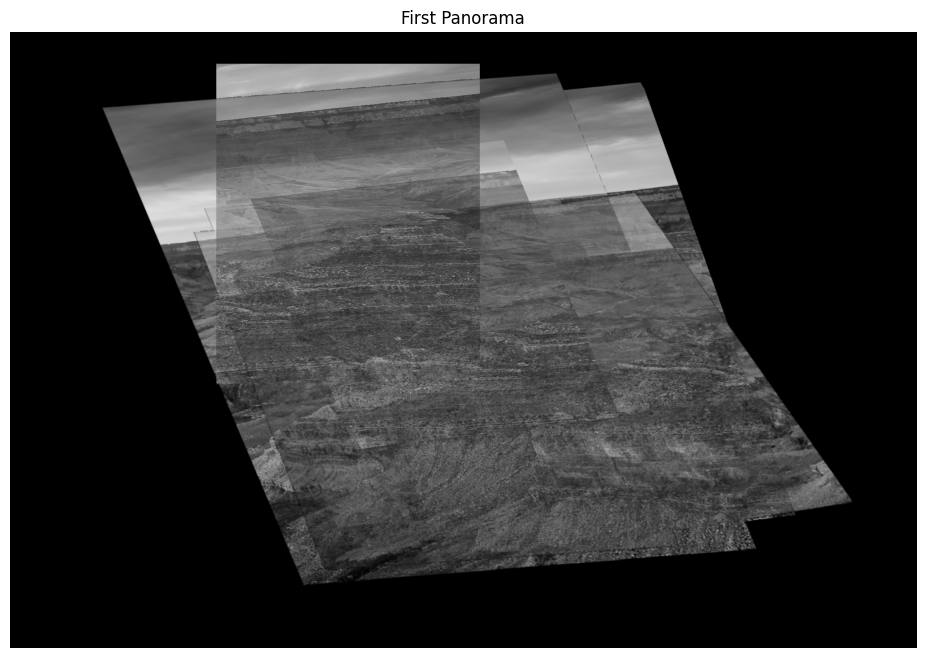

In [50]:
panorama_1 = stitch_images(clustered_images_1[0])

plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(panorama_1, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("First Panorama")
plt.show()

1


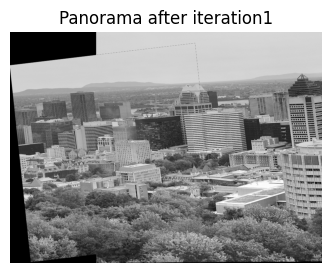

2


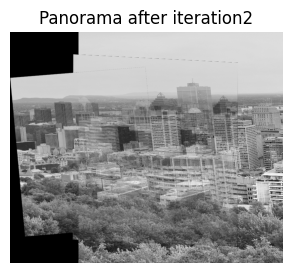

3


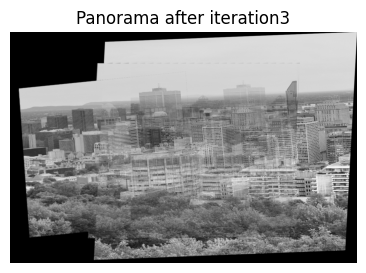

4


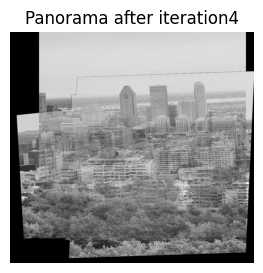

5


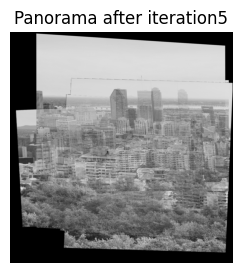

6


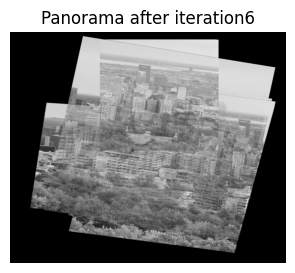

7


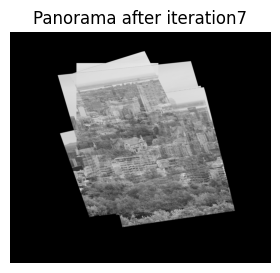

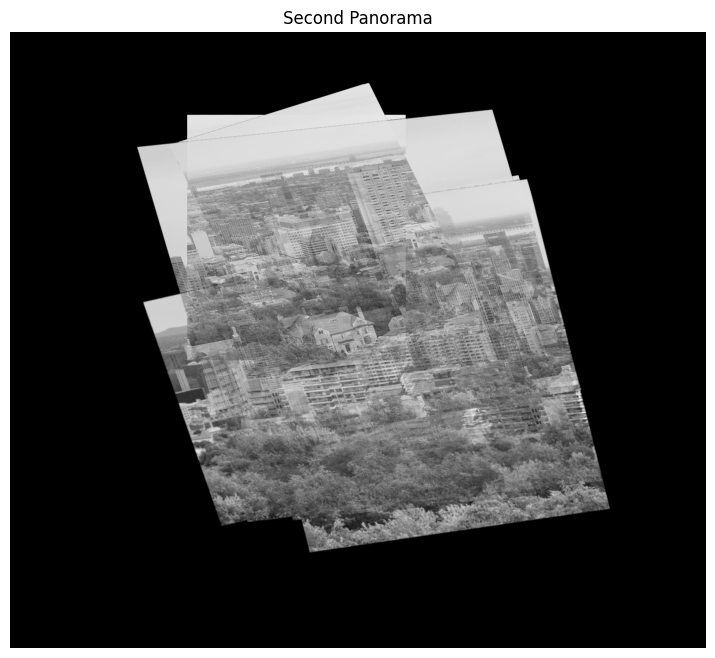

In [51]:
panorama_2 = stitch_images(clustered_images_1[1])

plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(panorama_2, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Second Panorama")
plt.show()

1


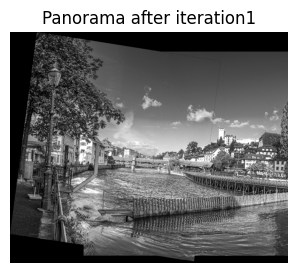

2


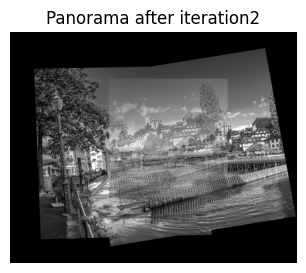

3


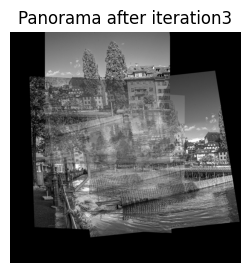

4


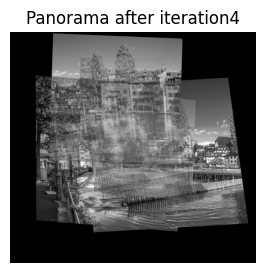

5


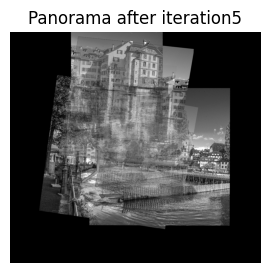

6


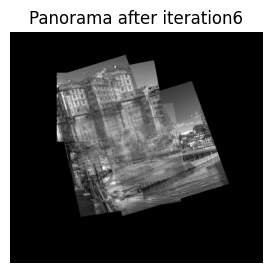

7


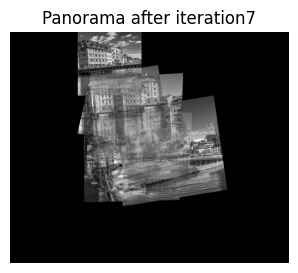

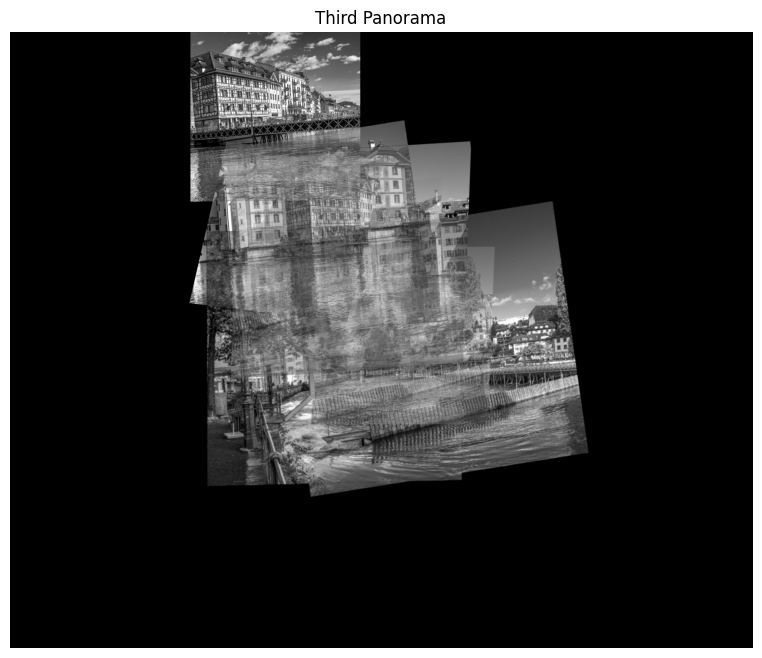

In [52]:
panorama_3 = stitch_images(clustered_images_1[2])

plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(panorama_3, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Third Panorama")
plt.show()